In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from deepracer.tracks import TrackIO, Track
from deepracer.logs import CloudWatchLogs as cw, \
    SimulationLogsIO as slio, \
    AnalysisUtils as au, \
    PlottingUtils as pu

In [2]:
!ls tracks/

AmericasGeneratedInclStart.npy	New_York_Eval_Track.npy
AWS_track.npy			New_York_Track.npy
Bowtie_track.npy		Oval_track.npy
Canada_Eval.npy			reInvent2019_track.npy
Canada_Training.npy		reInvent2019_wide_mirrored.npy
China_eval_track.npy		reInvent2019_wide.npy
China_track.npy			reinvent_base.npy
H_track.npy			Spain_track.npy
LGSWide.npy			Straight_track.npy
London_Loop_Train.npy		Tokyo_Training_track.npy
Mexico_track_eval.npy		Vegas_track.npy
Mexico_track.npy		Virtual_May19_Train_track.npy


In [3]:
tu = TrackIO()

In [4]:
track = tu.load_track("Spain_track")

Loaded 259 waypoints


In [5]:
stream_name = 'sim-l0zkv7d2vdwx' ## CHANGE This to your simulation application ID
fname = 'logs/deepracer-%s.log' %stream_name  # The log will be downloaded into the specified path

In [6]:
cw.download_log(fname, stream_prefix=stream_name)  # add force=True if you downloaded the file before but want to repeat

Log file exists, use force=True to download again


In [7]:
EPISODES_PER_ITERATION = 30 #  Set to value of your hyperparameter in training

data = slio.load_data(fname)
df = slio.convert_to_pandas(data, episodes_per_iteration=EPISODES_PER_ITERATION)

df = df.sort_values(['episode', 'steps'])

In [8]:
df

,iteration,episode,steps,x,y,yaw,steer,throttle,action,reward,done,on_track,progress,closest_waypoint,track_len,timestamp
0,1,0,3,0.1861,-2.1730,179.9723,-10.0,2.0,2.0,1.0201,0,True,0.2694,1,60.0,1589991672.663202
1,1,0,4,0.1476,-2.1723,179.7591,-10.0,2.0,2.0,1.0961,0,True,0.3335,1,60.0,1589991672.721318
2,1,0,5,0.1160,-2.1713,179.4298,0.0,2.1,3.0,1.0790,0,True,0.3862,1,60.0,1589991672.7924757
3,1,0,6,0.0617,-2.1694,178.9623,10.0,2.0,4.0,1.1357,0,True,0.4767,1,60.0,1589991672.8670764
4,1,0,7,-0.0104,-2.1666,178.4792,10.0,2.0,4.0,1.1803,0,True,0.5969,1,60.0,1589991672.9330971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31700,10,286,110,0.0049,2.7641,53.5371,-10.0,2.0,2.0,1.7512,0,True,21.3351,135,60.0,1589995195.4629934
31701,10,286,111,0.0407,2.8209,55.8679,-10.0,2.0,2.0,1.1659,0,True,21.4456,135,60.0,1589995195.5056581
31702,10,286,112,0.0736,2.8766,57.3948,0.0,2.1,3.0,1.1605,0,True,21.5526,136,60.0,1589995195.5654278
31703,10,286,113,0.1353,2.9946,60.6939,0.0,2.1,3.0,1.3684,0,True,21.7982,136,60.0,1589995195.6295726


In [9]:
df['action'].value_counts().sort_index()

0.0    7498
1.0    3387
2.0    4485
3.0    2910
4.0    3610
5.0    5363
6.0    4452
Name: action, dtype: int64

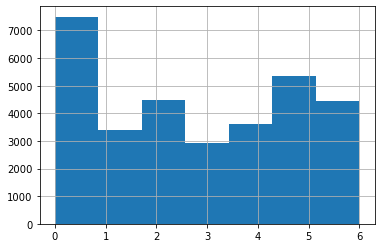

In [10]:
df['action'].hist(bins=7)

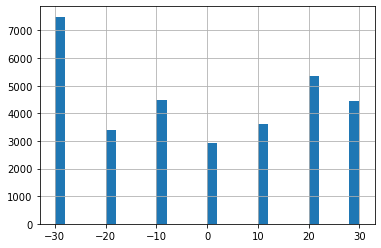

In [11]:
df['steer'].hist(bins=30)

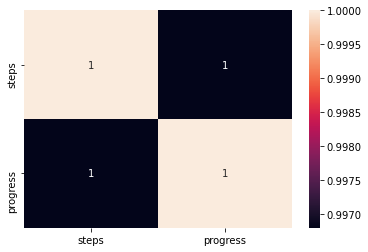

In [52]:
sns.heatmap(df[['steps', 'progress']].corr(), annot=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb2d77ad610>,
      dtype=object)

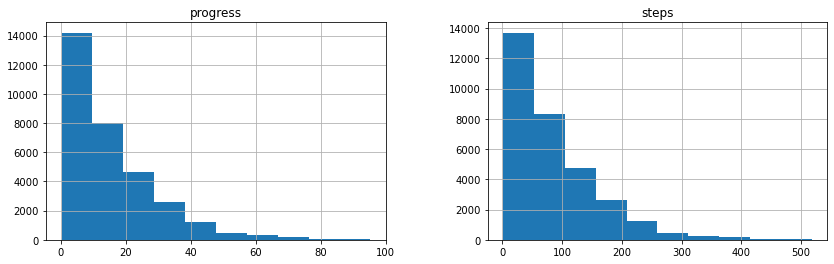

In [59]:
df[['steps', 'progress']].hist(figsize=(14,4))

In [39]:
from rewards.prototype import reward_function
import math

In [13]:
def plot_track(t):
    ratio = (lambda x,y: x / y)(*t.size())
    fig = plt.figure(figsize=(16,16/ratio))
    ax = fig.add_subplot()
    ax.plot(*t.center_line.T, 'b')
    ax.plot(*t.outer_border.T, 'b')
    ax.plot(*t.inner_border.T, 'b')
    return ax

In [14]:
def df2params(frame, track: Track, mapping=None):
    if mapping is None:
        mapping = {'on_track':'all_wheels_on_track', 'throttle':'speed',
                   'yaw':'heading', 'steer':'steering', 'track_len':'track_length', 'progress':'progress', 'steps':'steps'}
    d = {'closest_waypoints': [frame['closest_waypoint'], (frame['closest_waypoint']+1)%len(track.center_line)]}
    d.update({'is_reversed':False, 'waypoints':track.center_line})
    d.update({mapping[k]:frame[k] for k in mapping})
    return d

In [40]:
df['new_reward'] = [1 + reward_function(df2params(r, track)) for _,r in df.iterrows()]
df['newl_reward'] = [math.log(1 + r['new_reward']) for _,r in df.iterrows()]

In [41]:
df['log_reward'] = [math.log(1 + r['reward']) for _,r in df.iterrows()]

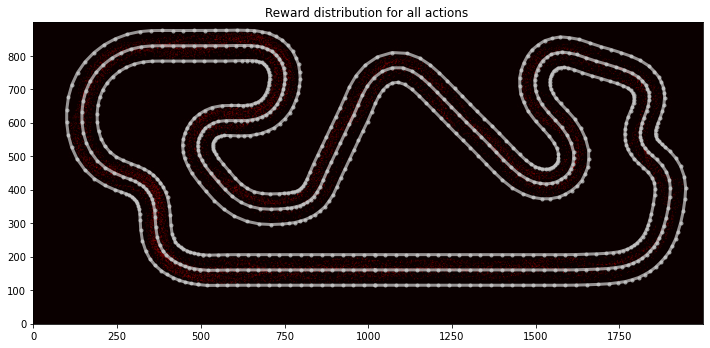

<Figure size 432x288 with 0 Axes>

In [42]:
pu.plot_track(df.sample(frac=0.5), track, value_field='log_reward')

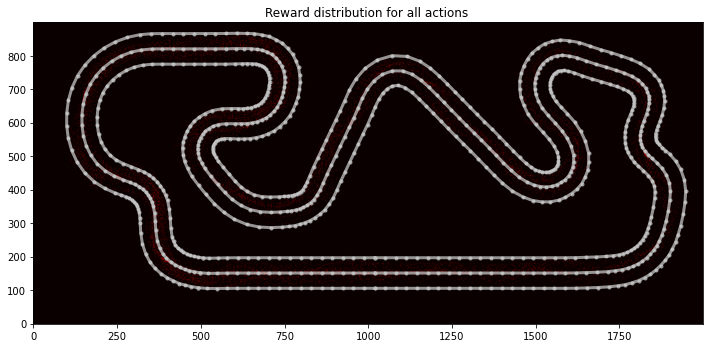

<Figure size 432x288 with 0 Axes>

In [43]:
pu.plot_track(df.sample(frac=0.5), track, value_field='newl_reward')

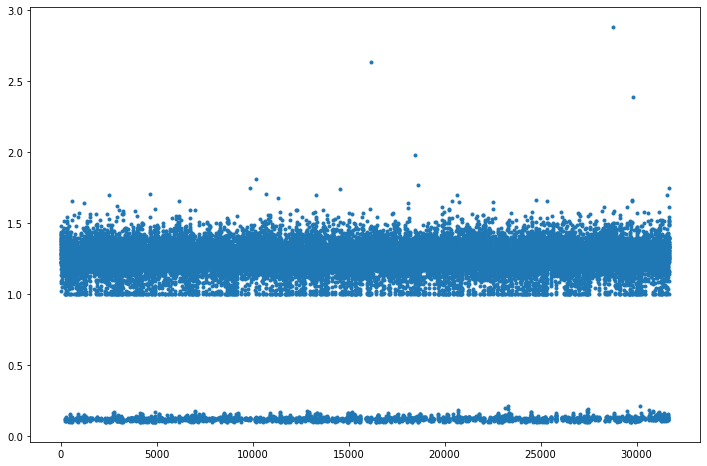

In [44]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(0,len(df)), df['reward'], '.')

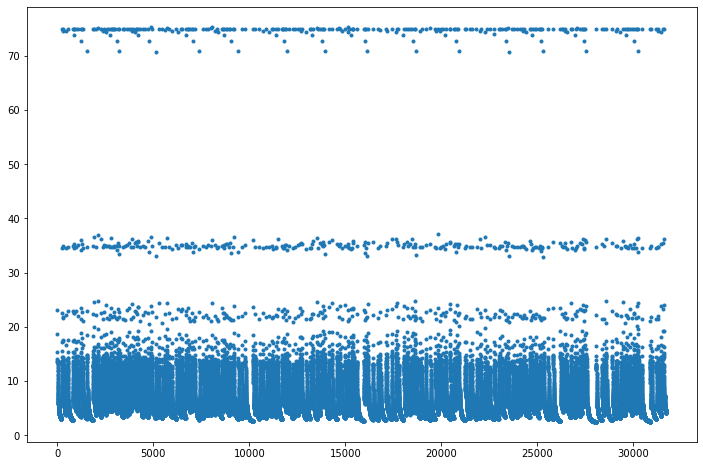

In [45]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(0,len(df)), df['new_reward'], '.')

In [21]:
df['log_progress'] = [math.log(1.0 + r['progress'] / 10.0) for _,r in df.iterrows()]

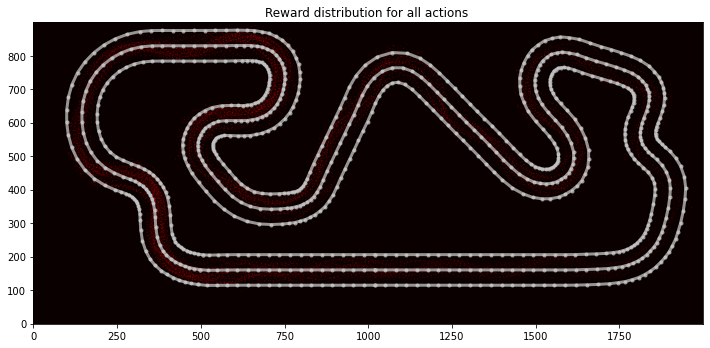

<Figure size 432x288 with 0 Axes>

In [22]:
pu.plot_track(df, track, value_field='log_progress', margin=1)

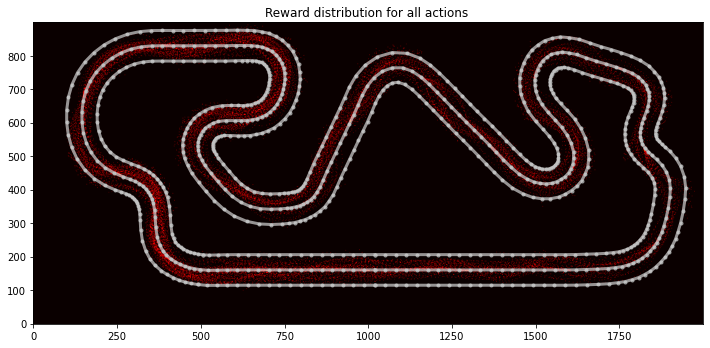

<Figure size 432x288 with 0 Axes>

In [23]:
pu.plot_track(df, track, value_field='throttle', margin=1)

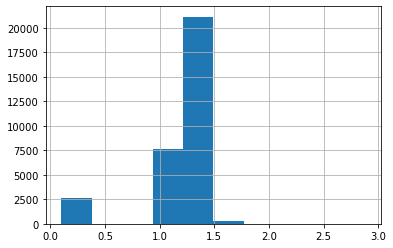

In [24]:
df['reward'].hist()

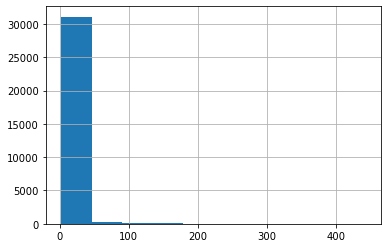

In [25]:
df['new_reward'].hist()

# Tempo experiment

In [26]:
def tempo(progress):
    result = np.zeros(len(progress))
    last = 0.0
    for x in range(0,len(progress)):
        if last > progress[x]:
            d = 0.0
        else:
            d = progress[x] - last
        result[x] = d
        last = float(progress[x])
    return result

In [27]:
df['tempo'] = tempo(df['progress']) * df['track_len'][0]

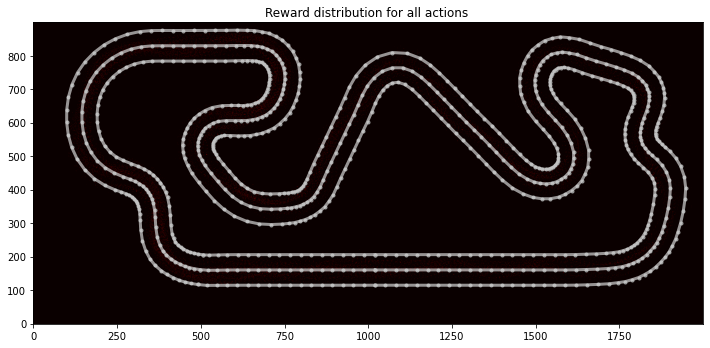

<Figure size 432x288 with 0 Axes>

In [28]:
pu.plot_track(df, track, value_field='tempo')

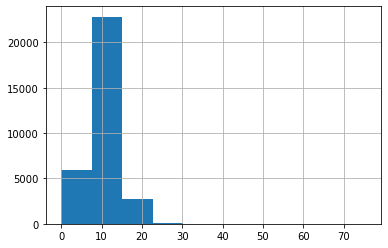

In [29]:
df['tempo'].hist()

# Key test

In [106]:
DENSITY = 2.0
key = lambda wpt: [int(round(c * DENSITY)) / DENSITY for c in wpt]
keys = np.array([key(w) for w in track.center_line])

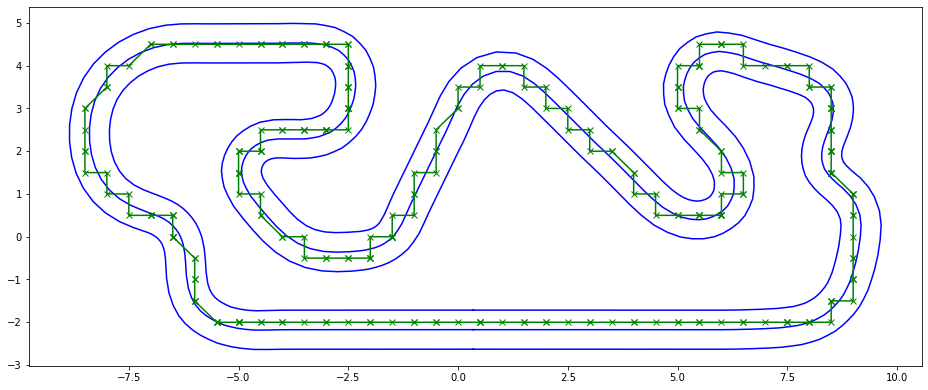

In [107]:
ax = plot_track(track)
ax.plot(*keys.T, 'gx-')

In [2]:
def plot3d_reward(x, y, r):
    X, Y = np.meshgrid(x, y)
    Z = r(X, Y)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X,Y,Z)
    return ax

In [ ]:
    def plot_track(df, track: Track, value_field="reward", margin=1, cmap="hot"):
        """Plot track with dots presenting the rewards for steps
        """
        track_size = (np.asarray(track.size()) + 2*margin).astype(int) * 100
        track_img = np.zeros(track_size).transpose()

        x_coord = 0
        y_coord = 1

        # compensation moves car's coordinates in logs to start at 0 in each dimention
        x_compensation = df['x'].min()
        y_compensation = df['y'].min()

        for _, row in df.iterrows():
            x = int((row["x"] - x_compensation + margin) * 100)
            y = int((row["y"] - y_compensation + margin) * 100)

            # clip values that are off track
            if y >= track_size[y_coord]:
                y = track_size[y_coord] - 1

            if x >= track_size[x_coord]:
                x = track_size[x_coord] - 1

            track_img[y, x] = row[value_field]

        fig = plt.figure(1, figsize=(12, 16))
        ax = fig.add_subplot(111)

        shifted_track = Track("shifted_track", (track.waypoints -
                                                [x_compensation, y_compensation]*3 + margin) * 100)

        PlottingUtils.print_border(ax, shifted_track)

        plt.title("Reward distribution for all actions ")
        plt.imshow(track_img, cmap=cmap, interpolation='bilinear', origin="lower")

        plt.show()
        plt.clf()
